In [103]:
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
df=pd.read_csv('houseprice.csv',usecols=["SalePrice", "MSSubClass", "MSZoning", "LotFrontage", "LotArea",
                                         "Street", "YearBuilt", "LotShape", "1stFlrSF", "2ndFlrSF"]).dropna()
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,YearBuilt,1stFlrSF,2ndFlrSF,SalePrice
0,60,RL,65.0,8450,Pave,Reg,2003,856,854,208500
1,20,RL,80.0,9600,Pave,Reg,1976,1262,0,181500
2,60,RL,68.0,11250,Pave,IR1,2001,920,866,223500
3,70,RL,60.0,9550,Pave,IR1,1915,961,756,140000
4,60,RL,84.0,14260,Pave,IR1,2000,1145,1053,250000


In [7]:
df.shape

(1201, 10)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1201 entries, 0 to 1459
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MSSubClass   1201 non-null   int64  
 1   MSZoning     1201 non-null   object 
 2   LotFrontage  1201 non-null   float64
 3   LotArea      1201 non-null   int64  
 4   Street       1201 non-null   object 
 5   LotShape     1201 non-null   object 
 6   YearBuilt    1201 non-null   int64  
 7   1stFlrSF     1201 non-null   int64  
 8   2ndFlrSF     1201 non-null   int64  
 9   SalePrice    1201 non-null   int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 103.2+ KB


In [10]:
for i in df.columns:
    print('Column Name : {} and unique values are : {}'.format(i,len(df[i].unique())))

Column Name : MSSubClass and unique values are : 15
Column Name : MSZoning and unique values are : 5
Column Name : LotFrontage and unique values are : 110
Column Name : LotArea and unique values are : 869
Column Name : Street and unique values are : 2
Column Name : LotShape and unique values are : 4
Column Name : YearBuilt and unique values are : 112
Column Name : 1stFlrSF and unique values are : 678
Column Name : 2ndFlrSF and unique values are : 368
Column Name : SalePrice and unique values are : 597


Based on the number of unique values we can predict that `MSSubClass, MSZoning, Street, LotShape` are Categorical features whereas rest are Continuous features.

In [13]:
dt.datetime.now().year

2022

In [14]:
df['Total Years'] = dt.datetime.now().year - df['YearBuilt']

In [15]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,YearBuilt,1stFlrSF,2ndFlrSF,SalePrice,Total Years
0,60,RL,65.0,8450,Pave,Reg,2003,856,854,208500,19
1,20,RL,80.0,9600,Pave,Reg,1976,1262,0,181500,46
2,60,RL,68.0,11250,Pave,IR1,2001,920,866,223500,21
3,70,RL,60.0,9550,Pave,IR1,1915,961,756,140000,107
4,60,RL,84.0,14260,Pave,IR1,2000,1145,1053,250000,22


In [16]:
df.drop('YearBuilt', axis=1, inplace=True)

In [17]:
df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', '1stFlrSF', '2ndFlrSF', 'SalePrice', 'Total Years'],
      dtype='object')

In [18]:
# Creating Categorical Features
cat_features = ['MSSubClass', 'MSZoning', 'Street', 'LotShape']
out_features = ['SalePrice']

In [20]:
df['MSSubClass'].unique()

array([ 60,  20,  70,  50, 190,  45,  90, 120,  30,  80, 160,  75, 180,
        40,  85], dtype=int64)

In [21]:
lbl_encoders = {}
for feature in cat_features:
    lbl_encoders[feature] = LabelEncoder()
    df[feature] = lbl_encoders[feature].fit_transform(df[feature])

In [22]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,1stFlrSF,2ndFlrSF,SalePrice,Total Years
0,5,3,65.0,8450,1,3,856,854,208500,19
1,0,3,80.0,9600,1,3,1262,0,181500,46
2,5,3,68.0,11250,1,0,920,866,223500,21
3,6,3,60.0,9550,1,0,961,756,140000,107
4,5,3,84.0,14260,1,0,1145,1053,250000,22


In [45]:
# Stacking and converting into Tensors
cat_features = np.stack([df['MSSubClass'], df['MSZoning'], df['Street'], df['LotShape']],axis=1)
cat_features

array([[5, 3, 1, 3],
       [0, 3, 1, 3],
       [5, 3, 1, 0],
       ...,
       [6, 3, 1, 3],
       [0, 3, 1, 3],
       [0, 3, 1, 3]], dtype=int64)

The categorical features get converted into numpy and are stacked columnwise and then we convert them into PyTorch Tensors.

In [46]:
# Converting numpy to Tensors
cat_features = torch.tensor(cat_features,dtype=torch.int64) # Never convert categorical features into float
cat_features

tensor([[5, 3, 1, 3],
        [0, 3, 1, 3],
        [5, 3, 1, 0],
        ...,
        [6, 3, 1, 3],
        [0, 3, 1, 3],
        [0, 3, 1, 3]])

In [62]:
# Creating Continuous variable
cont_features = []
for i in df.columns:
    if i in ['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'SalePrice']:
        pass
    else:
        cont_features.append(i)

In [63]:
cont_features

['LotFrontage', 'LotArea', '1stFlrSF', '2ndFlrSF', 'Total Years']

In [64]:
# Stacking continuous variable to a tensor
cont_values = np.stack([df[i].values for i in cont_features],axis=1)
cont_values = torch.tensor(cont_values,dtype=torch.float)
cont_values

tensor([[   65.,  8450.,   856.,   854.,    19.],
        [   80.,  9600.,  1262.,     0.,    46.],
        [   68., 11250.,   920.,   866.,    21.],
        ...,
        [   66.,  9042.,  1188.,  1152.,    81.],
        [   68.,  9717.,  1078.,     0.,    72.],
        [   75.,  9937.,  1256.,     0.,    57.]])

In [65]:
# Dependent feature
y = torch.tensor(df['SalePrice'].values,dtype=torch.float).reshape(-1,1)
y

tensor([[208500.],
        [181500.],
        [223500.],
        ...,
        [266500.],
        [142125.],
        [147500.]])

In [66]:
cat_features.shape,cont_values.shape,y.shape

(torch.Size([1201, 4]), torch.Size([1201, 5]), torch.Size([1201, 1]))

#### Embedding size for Categorical columns

In [67]:
cat_dims = [len(df[col].unique()) for col in ['MSSubClass', 'MSZoning', 'Street', 'LotShape']]
cat_dims

[15, 5, 2, 4]

### Output dimension should be set based on the input dimension (min(50,feature dimension/2))

In [68]:
embedding_dim = [(x , min(50,(x + 1)//2)) for x in cat_dims]
embedding_dim

[(15, 8), (5, 3), (2, 1), (4, 2)]

In [81]:
embed_representation = nn.ModuleList([nn.Embedding(inp,out) for inp,out in embedding_dim])
embed_representation

ModuleList(
  (0): Embedding(15, 8)
  (1): Embedding(5, 3)
  (2): Embedding(2, 1)
  (3): Embedding(4, 2)
)

In [82]:
cat_feat = cat_features[:4]
cat_feat

tensor([[5, 3, 1, 3],
        [0, 3, 1, 3],
        [5, 3, 1, 0],
        [6, 3, 1, 0]])

In [83]:
embedding_val = []
for i,e in enumerate(embed_representation):
    embedding_val.append(e(cat_features[:,i]))

In [84]:
embedding_val

[tensor([[-0.5881, -2.2164, -1.1353,  ...,  0.2204, -0.5373, -0.4884],
         [-0.0853, -2.8067, -1.2215,  ...,  1.1604,  1.8321,  0.7968],
         [-0.5881, -2.2164, -1.1353,  ...,  0.2204, -0.5373, -0.4884],
         ...,
         [-0.9191, -0.6873,  0.3636,  ...,  0.1205, -0.7625,  0.1945],
         [-0.0853, -2.8067, -1.2215,  ...,  1.1604,  1.8321,  0.7968],
         [-0.0853, -2.8067, -1.2215,  ...,  1.1604,  1.8321,  0.7968]],
        grad_fn=<EmbeddingBackward0>),
 tensor([[-0.3936,  0.7284,  1.0284],
         [-0.3936,  0.7284,  1.0284],
         [-0.3936,  0.7284,  1.0284],
         ...,
         [-0.3936,  0.7284,  1.0284],
         [-0.3936,  0.7284,  1.0284],
         [-0.3936,  0.7284,  1.0284]], grad_fn=<EmbeddingBackward0>),
 tensor([[0.4306],
         [0.4306],
         [0.4306],
         ...,
         [0.4306],
         [0.4306],
         [0.4306]], grad_fn=<EmbeddingBackward0>),
 tensor([[ 0.4060,  0.1789],
         [ 0.4060,  0.1789],
         [-0.6401,  0.3469],

In [85]:
z = torch.cat(embedding_val,axis=1)
z

tensor([[-0.5881, -2.2164, -1.1353,  ...,  0.4306,  0.4060,  0.1789],
        [-0.0853, -2.8067, -1.2215,  ...,  0.4306,  0.4060,  0.1789],
        [-0.5881, -2.2164, -1.1353,  ...,  0.4306, -0.6401,  0.3469],
        ...,
        [-0.9191, -0.6873,  0.3636,  ...,  0.4306,  0.4060,  0.1789],
        [-0.0853, -2.8067, -1.2215,  ...,  0.4306,  0.4060,  0.1789],
        [-0.0853, -2.8067, -1.2215,  ...,  0.4306,  0.4060,  0.1789]],
       grad_fn=<CatBackward0>)

In [86]:
# Implementing Dropout
dropout = nn.Dropout(0.4)

In [87]:
final_embed = dropout(z)
final_embed

tensor([[-0.9802, -0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.2981],
        [-0.0000, -0.0000, -2.0358,  ...,  0.7177,  0.6766,  0.2981],
        [-0.0000, -0.0000, -0.0000,  ...,  0.0000, -1.0669,  0.0000],
        ...,
        [-1.5318, -0.0000,  0.6059,  ...,  0.7177,  0.6766,  0.2981],
        [-0.0000, -0.0000, -2.0358,  ...,  0.7177,  0.0000,  0.2981],
        [-0.0000, -4.6779, -0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       grad_fn=<MulBackward0>)

In [111]:
# Creating a Feed Forward NN

class FeedForwardNN(nn.Module):
    
    def __init__(self, embedding_dim, n_cont, out_sz ,layers, p=0.5):
        super().__init__()        
        self.embeds = nn.ModuleList([nn.Embedding(inp,out) for inp,out in embedding_dim])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((out for inp,out in embedding_dim))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
        self.layers = nn.Sequential(*layerlist)
        
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [112]:
torch.manual_seed(100)
model = FeedForwardNN(embedding_dim,len(cont_features),1,[100,50],p=0.4)

In [113]:
model

FeedForwardNN(
  (embeds): ModuleList(
    (0): Embedding(15, 8)
    (1): Embedding(5, 3)
    (2): Embedding(2, 1)
    (3): Embedding(4, 2)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=19, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=100, out_features=50, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=50, out_features=1, bias=True)
  )
)

### Defining Loss and Optimizer

In [114]:
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

In [115]:
# Train-Test split
batch_size = 1200
test_size = int(batch_size * 0.2)
train_categorical = cat_features[:batch_size-test_size]
test_categorical = cat_features[batch_size-test_size:batch_size]
train_cont = cont_values[:batch_size-test_size]
test_cont = cont_values[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [116]:
len(train_categorical),len(test_categorical),len(train_cont),len(test_cont),len(y_train),len(y_test)

(960, 240, 960, 240, 960, 240)

In [117]:
epochs = 5000
final_losses = []
for i in range(epochs):
    i=i+1
    y_pred=model(train_categorical,train_cont)
    loss=torch.sqrt(loss_function(y_pred,y_train)) ### RMSE
    final_losses.append(loss)
    if i%10==1:
        print("Epoch number: {} and the loss : {}".format(i,loss.item()))
    optimizer.zero_grad()
    loss.backward() # Back Propagation
    optimizer.step()

Epoch number: 1 and the loss : 199209.984375
Epoch number: 11 and the loss : 199206.734375
Epoch number: 21 and the loss : 199202.328125
Epoch number: 31 and the loss : 199195.90625
Epoch number: 41 and the loss : 199186.5625
Epoch number: 51 and the loss : 199174.578125
Epoch number: 61 and the loss : 199159.828125
Epoch number: 71 and the loss : 199142.859375
Epoch number: 81 and the loss : 199121.4375
Epoch number: 91 and the loss : 199097.4375
Epoch number: 101 and the loss : 199069.25
Epoch number: 111 and the loss : 199035.671875
Epoch number: 121 and the loss : 199004.28125
Epoch number: 131 and the loss : 198967.28125
Epoch number: 141 and the loss : 198920.078125
Epoch number: 151 and the loss : 198877.265625
Epoch number: 161 and the loss : 198827.671875
Epoch number: 171 and the loss : 198773.96875
Epoch number: 181 and the loss : 198719.046875
Epoch number: 191 and the loss : 198661.96875
Epoch number: 201 and the loss : 198594.859375
Epoch number: 211 and the loss : 198533

Epoch number: 1791 and the loss : 152638.078125
Epoch number: 1801 and the loss : 152856.34375
Epoch number: 1811 and the loss : 151731.765625
Epoch number: 1821 and the loss : 151084.78125
Epoch number: 1831 and the loss : 151296.9375
Epoch number: 1841 and the loss : 150788.0
Epoch number: 1851 and the loss : 149700.375
Epoch number: 1861 and the loss : 149713.34375
Epoch number: 1871 and the loss : 149081.40625
Epoch number: 1881 and the loss : 148399.25
Epoch number: 1891 and the loss : 147587.09375
Epoch number: 1901 and the loss : 147758.984375
Epoch number: 1911 and the loss : 147958.0625
Epoch number: 1921 and the loss : 146538.40625
Epoch number: 1931 and the loss : 146311.125
Epoch number: 1941 and the loss : 145699.1875
Epoch number: 1951 and the loss : 146242.625
Epoch number: 1961 and the loss : 145383.234375
Epoch number: 1971 and the loss : 144613.8125
Epoch number: 1981 and the loss : 144865.9375
Epoch number: 1991 and the loss : 144546.40625
Epoch number: 2001 and the 

Epoch number: 3551 and the loss : 67667.6875
Epoch number: 3561 and the loss : 66280.2890625
Epoch number: 3571 and the loss : 66242.890625
Epoch number: 3581 and the loss : 65652.7265625
Epoch number: 3591 and the loss : 66435.484375
Epoch number: 3601 and the loss : 64054.35546875
Epoch number: 3611 and the loss : 65066.99609375
Epoch number: 3621 and the loss : 64741.1171875
Epoch number: 3631 and the loss : 62909.08203125
Epoch number: 3641 and the loss : 64496.75390625
Epoch number: 3651 and the loss : 62075.35546875
Epoch number: 3661 and the loss : 63088.671875
Epoch number: 3671 and the loss : 61876.671875
Epoch number: 3681 and the loss : 61053.375
Epoch number: 3691 and the loss : 61408.26171875
Epoch number: 3701 and the loss : 59663.0625
Epoch number: 3711 and the loss : 61221.84765625
Epoch number: 3721 and the loss : 58816.21875
Epoch number: 3731 and the loss : 57631.1484375
Epoch number: 3741 and the loss : 57619.93359375
Epoch number: 3751 and the loss : 58896.76171875

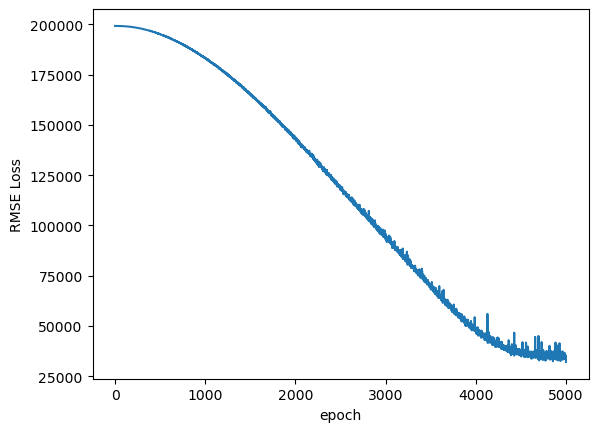

In [119]:
fi_loss = [fl.item() for fl in final_losses]
plt.plot(range(epochs), fi_loss)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch');

In [120]:
# Validate the Test Data
y_pred = ''
with torch.no_grad():
    y_pred = model(test_categorical, test_cont)
    loss = torch.sqrt(loss_function(y_pred, y_test))
print('RMSE: {}'.format(loss))

RMSE: 45568.546875


In [121]:
# Saving the model
torch.save(model,'HousePrice.pt')
torch.save(model.state_dict(),'HouseWeights.pt')

In [122]:
# Loading the saved Model
embs_size=[(15, 8), (5, 3), (2, 1), (4, 2)]
model1=FeedForwardNN(embs_size, 5, 1, [100,50], p=0.4)

In [123]:
model1.load_state_dict(torch.load('HouseWeights.pt'))

<All keys matched successfully>

In [124]:
model1.eval()

FeedForwardNN(
  (embeds): ModuleList(
    (0): Embedding(15, 8)
    (1): Embedding(5, 3)
    (2): Embedding(2, 1)
    (3): Embedding(4, 2)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=19, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=100, out_features=50, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=50, out_features=1, bias=True)
  )
)